In [29]:
import numpy as np
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/modules/'
import sys
sys.path.append(module_path)
import pandas as pd
from sklearn.neighbors import BallTree
import math
from itertools import combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(999)

In [174]:
galfile = pd.read_hdf('/scratch/data/galcats/P200/galaxies.Z01.h5')
#galfile = pd.read_hdf('test_galcat.h5')
galaxies = galfile.as_matrix()
gal_header = galfile.keys().tolist()
print(gal_header)
print(np.shape(galaxies))

['X_pos', 'Y_pos', 'Z_pos', 'X_vel', 'Y_vel', 'Z_vel', 'Halo_mass', 'Stellar_mass', 'SFR', 'Intra_cluster_mass', 'Halo_mass_peak', 'Stellar_mass_obs', 'SFR_obs', 'Halo_radius', 'Concentration', 'Halo_spin', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM', 'Type']
(594946, 20)


In [47]:
data_dict = {'X_pos': 0, 'Y_pos': 1, 'Z_pos': 2, 'X_vel': 3, 'Y_vel': 4, 'Z_vel': 5, 'Halo_mass': 6, 
             'Stellar_mass': 7, 'SFR': 8, 'Intra_cluster_mass': 9, 'Halo_mass_peak': 10, 'Stellar_mass_obs': 11, 
             'SFR_obs': 12, 'Halo_radius': 13, 'Concentration': 14, 'Halo_spin': 15, 'Scale_peak_mass': 16, 
             'Scale_half_mass': 17, 'Scale_last_MajM': 18, 'Type': 19}

In [175]:
nr_neighbours_wanted = 10
nr_dims = 3
halo_masses = galaxies[:, 6]
borders_list = [[0, 200], [0, 200], [0, 200]] # [[x1min, x1max], ... , [xNmin, xNmax]]

### Make sure that the edges are what they should be
print(np.min(galaxies[:, 0]), np.max(galaxies[:, 0]))
print(np.min(galaxies[:, 1]), np.max(galaxies[:, 1]))
print(np.min(galaxies[:, 2]), np.max(galaxies[:, 2]))

0.00061974325 199.99994
0.00010329054 199.99971
0.0005164527 199.99997


In [176]:
### Start of func
### OBS ONLY WORKS FOR A MODERATE AMOUNT OF NEIGHBORS. IF THE NUMBER OF NEIGHBORS WANTED IS 
### TOO HIGH THEN THIS WILL NOT BE ACCURATE (too high = )
coordinates = galaxies[:, :nr_dims].tolist()
if not isinstance(halo_masses, list):
    masses = halo_masses.tolist()
else:
    masses = halo_masses
    

nr_points = len(coordinates)
original_box_volume = 1
box_sides = [] # contains the length of the box in all dimensions
for borders in borders_list:
    original_box_volume *= (borders[1] - borders[0])
    box_sides.append(borders[1] - borders[0])
original_vol_per_point = original_box_volume / np.size(coordinates, 0)
dist_between_points = np.power(original_vol_per_point, 1/3)
buffer_dist = dist_between_points * nr_neighbours_wanted
#print(borders_list)
#print('%.1e' % (volume))
print('volume per point before additions of points: %.1e' % (original_vol_per_point))
#print(dist_between_points)
print('buffer distance = ', buffer_dist)
partitions_list = []

for orig_borders in borders_list:
    if (buffer_dist < orig_borders[1] - orig_borders[0]):
        partitions_list.append([orig_borders[0] + buffer_dist, orig_borders[1] - buffer_dist])
    else:
        partitions_list.append([(orig_borders[1] - orig_borders[0])/2 + orig_borders[0],
                       (orig_borders[1] - orig_borders[0])/2 + orig_borders[0]])

print(borders_list)
print('partitions:' ,partitions_list)

inner_volume = 1
for partitions in partitions_list:
    inner_volume *= (partitions[1] - partitions[0])

inner_points_indices = []
outer_points_indices = []

#check nr of duplicated in the list of coordinates
list_of_strings = []
for lst in coordinates:
    string = ''.join(str(e) for e in lst)
    list_of_strings.append(string)
full_nr = len(list_of_strings)
set_nr = len(set(list_of_strings))
print('Before point addition, number of duplicates are: %d - %d = %d.' % (full_nr, set_nr, full_nr - set_nr))

for i in range(nr_points):
    outside_array = np.zeros(nr_dims) # +1: below lower bound, -1: above upper bound
    for i_dim, partitions in enumerate(partitions_list):
        if coordinates[i][i_dim] < partitions[0]: 
            outside_array[i_dim] = 1 
        elif coordinates[i][i_dim] > partitions[1]:
            outside_array[i_dim] = -1
            
    
    if not np.any(outside_array): # check if point is inside inner box
        
        inner_points_indices.append(i)

    else:
        
        dims_crossed = np.nonzero(outside_array)[0]
        outer_points_indices.append(i)

        # add across one dim
        for dim in dims_crossed:
            masses.append(masses[i])

            addition_array = np.zeros(nr_dims)
            addition_array[dim] = outside_array[dim]
            coordinates.append(coordinates[i])
            coordinates[-1] += addition_array*box_sides

        # add across two dims
        combs = list(combinations(dims_crossed, 2))

        for comb in combs:

            masses.append(masses[i])

            addition_array = np.zeros(nr_dims)
            for dim in comb:
                addition_array[dim] = outside_array[dim]
#                print(comb, addition_array)

            coordinates.append(coordinates[i])
            coordinates[-1] += addition_array*box_sides

        # add across three dims
        combs = list(combinations(dims_crossed, 3))

        for comb in combs:

            masses.append(masses[i])

            addition_array = np.zeros(nr_dims)
            for dim in comb:
                addition_array[dim] = outside_array[dim]

            coordinates.append(coordinates[i])
            coordinates[-1] += addition_array*box_sides
            
#check nr of duplicated in the list of coordinates
list_of_strings = []
for lst in coordinates:
    string = ''.join(str(e) for e in lst)
    list_of_strings.append(string)
full_nr = len(list_of_strings)
set_nr = len(set(list_of_strings))
print('After point addition, number of duplicates are: %d - %d = %d.' % (full_nr, set_nr, full_nr - set_nr))

end_volume = 1
for i_dim in range(nr_dims):
    end_volume *= (box_sides[i_dim] + partitions_list[i_dim][0] - borders_list[i_dim][0] + borders_list[i_dim][1] - 
                   partitions_list[i_dim][1])
end_vol_per_point = end_volume / np.size(coordinates, 0)
print('volume per point after additions of points: %.1e' % (end_vol_per_point))

        
print(len(inner_points_indices), len(outer_points_indices))
print(inner_volume/original_box_volume, len(inner_points_indices)/nr_points)

if len(inner_points_indices) == 0:
    print('WARNING! Results are probably not accurate. Do you need this many neighbors?')

volume per point before additions of points: 1.3e+01
buffer distance =  23.779578152341657
[[0, 200], [0, 200], [0, 200]]
partitions: [[23.779578152341657, 176.22042184765834], [23.779578152341657, 176.22042184765834], [23.779578152341657, 176.22042184765834]]
Before point addition, number of duplicates are: 594946 - 594946 = 0.
After point addition, number of duplicates are: 1172216 - 1172216 = 0.
volume per point after additions of points: 1.3e+01
235994 358952
0.4428065580459245 0.3966645712383981


<IPython.core.display.Javascript object>


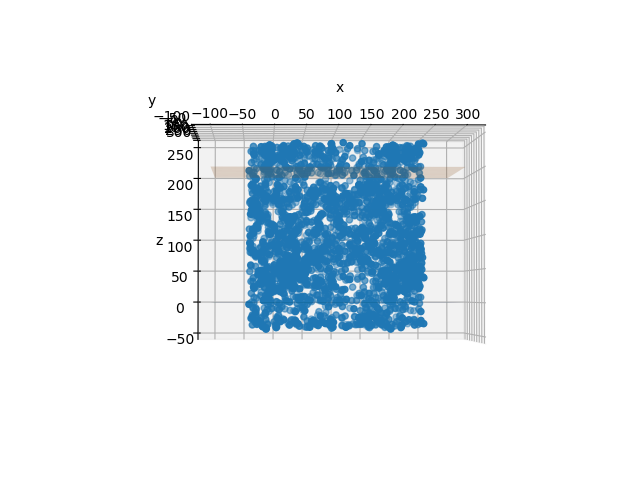

In [149]:
### Visualisation of points
%matplotlib notebook

np_coords = np.asarray(coordinates) 

plt3d = plt.figure().gca(projection='3d')
# plot the surfaces
X = np.arange(-100, 350, 50)
Y = np.arange(-100, 350, 50)
X, Y = np.meshgrid(X, Y)
Z1 = np.ones(np.shape(X)) * 0
Z2 = np.ones(np.shape(X)) * 200
plt3d.plot_surface(X, Y, Z1, alpha=0.2)
plt3d.plot_surface(X, Y, Z2, alpha=0.2)


# Ensure that the next plot doesn't overwrite the first plot
ax = plt.gca()

ax.scatter(np_coords[:,0], np_coords[:,1], 
           np_coords[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#fig = plt.figure(1, figsize=(8,8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(np_coords[:,0], np_coords[:,1], 
#           np_coords[:,2])
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
plt.show()

In [177]:
print(len(inner_points_indices), len(outer_points_indices))
print(len(coordinates))

235994 358952
1172216


In [186]:
tree = BallTree(coordinates, leaf_size=2)
neigh_densities = []
for i_point in range(nr_points):
    dist, ind = tree.query([coordinates[i_point]], k=nr_neighbours_wanted)
#    print(type(ind[0]))
#    print(dist, ind)
    sphere_radius = np.max(dist)
    print('sphere radius: ', sphere_radius)
    sphere_volume = (4/3) * math.pi * sphere_radius**3
    print('sphere volume: ', sphere_volume)
    neigh_masses = [masses[i] for i in ind[0]]
    density =  sum(neigh_masses) / sphere_volume
    print('density: ', density)
    neigh_densities.append(density)

sphere radius:  0.11465736811617062
sphere volume:  0.006313853708980204
density:  16280.922732447349
sphere radius:  0.08410392873041402
sphere volume:  0.002491939300693806
density:  40243.695070843634
sphere radius:  0.5263800883470485
sphere volume:  0.6109236913464379
density:  169.32922330406976
sphere radius:  0.7536700084454293
sphere volume:  1.7932147777115557
density:  57.55950269311749
sphere radius:  0.11332557311846261
sphere volume:  0.006096384939765515
density:  16645.74239132793
sphere radius:  0.1723675138454304
sphere volume:  0.021451361519102034
density:  4638.810296646384
sphere radius:  0.5825217171825442
sphere volume:  0.8279897728859542
density:  120.45929488835806
sphere radius:  0.13969460658669805
sphere volume:  0.011418985621656134
density:  8991.740262619793
sphere radius:  0.14854271931473328
sphere volume:  0.013729120589199175
density:  7440.415666716612
sphere radius:  0.17425646192840558
sphere volume:  0.022164364576501335
density:  4643.163919519

sphere radius:  0.15557332130896026
sphere volume:  0.015772261893131953
density:  6467.76714362914
sphere radius:  0.12411688379222544
sphere volume:  0.008009053576836326
density:  12478.112190558866
sphere radius:  0.210185369524092
sphere volume:  0.038895204308410626
density:  2671.5112918451964
sphere radius:  0.09795528025676448
sphere volume:  0.00393706118229398
density:  25973.642827294683
sphere radius:  0.23194857853241577
sphere volume:  0.052271354654210525
density:  1967.3826484356796
sphere radius:  0.12025948544340942
sphere volume:  0.0072852864619824724
density:  13761.985403611017
sphere radius:  0.23971030996209128
sphere volume:  0.057696404489782645
density:  1778.5359978544257
sphere radius:  0.15021282088454707
sphere volume:  0.014197426043781559
density:  7164.895767750967
sphere radius:  0.06738097477303875
sphere volume:  0.0012814464953377596
density:  78375.53404408696
sphere radius:  0.17354806110488372
sphere volume:  0.021895149125480864
density:  4562

sphere volume:  0.011145333110640527
density:  9224.907134914769
sphere radius:  0.21860166402689338
sphere volume:  0.043757147201943895
density:  2355.6237585883277
sphere radius:  0.1692341378492939
sphere volume:  0.020302640709847955
density:  4931.154331328205
sphere radius:  0.14312998036367366
sphere volume:  0.012282321024249476
density:  8328.580945389194
sphere radius:  0.16960300250927793
sphere volume:  0.020435685878516463
density:  4957.086246446275
sphere radius:  0.09035917241656166
sphere volume:  0.0030903334533741882
density:  33738.032423191944
sphere radius:  0.30492191498665067
sphere volume:  0.11875571671502196
density:  873.710870190055
sphere radius:  0.14669057350344775
sphere volume:  0.013221941423866531
density:  7806.88012394626
sphere radius:  0.2088288755463366
sphere volume:  0.03814698857642125
density:  2695.9585498747592
sphere radius:  0.11009906613655725
sphere volume:  0.00559035664430683
density:  18604.53932960803
sphere radius:  0.05324368187

density:  5183.44212589432
sphere radius:  0.14572565132553855
sphere volume:  0.0129627344574976
density:  7800.770170671042
sphere radius:  0.04621608007214954
sphere volume:  0.0004134927795168844
density:  247246.33046804843
sphere radius:  0.12494190276204038
sphere volume:  0.008169828803795687
density:  12106.679649898802
sphere radius:  0.12649864064833194
sphere volume:  0.008479030259532627
density:  12390.991509786581
sphere radius:  0.03338273747563441
sphere volume:  0.00015583121280501888
density:  642211.1040753664
sphere radius:  0.057398077141258316
sphere volume:  0.0007921011432374795
density:  128030.7788080329
sphere radius:  0.07305607594334412
sphere volume:  0.001633268676656561
density:  60995.44466853816
sphere radius:  0.08029720321575042
sphere volume:  0.002168651994409872
density:  46037.94907017729
sphere radius:  0.030655711596860098
sphere volume:  0.00012067653014911331
density:  828358.238807638
sphere radius:  0.07221714875514028
sphere volume:  0.00

sphere radius:  0.09460316234084638
sphere volume:  0.0035465457885355775
density:  27360.96301460336
sphere radius:  0.03832139555425447
sphere volume:  0.0002357287529079342
density:  432168.6728238764
sphere radius:  0.031353610402086195
sphere volume:  0.0001291074435826377
density:  765219.0401337568
sphere radius:  0.12613972816350916
sphere volume:  0.008407062605223071
density:  12048.763857630707
sphere radius:  0.052278792819566294
sphere volume:  0.0005985015248407742
density:  169263.70166968356
sphere radius:  0.024330435817150404
sphere volume:  6.033068746513154e-05
density:  1653758.663018465
sphere radius:  0.1273955232526356
sphere volume:  0.008660662406318156
density:  11489.827017008727
sphere radius:  0.05042729303869843
sphere volume:  0.0005371376270825466
density:  184720.40617632953
sphere radius:  0.04752640463443309
sphere volume:  0.0004496695637341578
density:  218841.88543122748
sphere radius:  0.03157760129461997
sphere volume:  0.00013189429782355268
de

sphere radius:  0.21182929303713166
sphere volume:  0.0398149944649066
density:  2535.8456059396094
sphere radius:  0.1670945686546284
sphere volume:  0.019542297027860134
density:  5103.5617741896785
sphere radius:  0.7445202159129716
sphere volume:  1.728693874720566
density:  58.118681106288214
sphere radius:  0.1536741215716462
sphere volume:  0.015201653430164351
density:  6445.885361143216
sphere radius:  0.1207940058901234
sphere volume:  0.007382862180788011
density:  13770.412951980372
sphere radius:  0.18156198606979873
sphere volume:  0.025070522401654922
density:  3963.6072457732885
sphere radius:  0.3526202963574694
sphere volume:  0.18365828628410508
density:  557.7284784602828
sphere radius:  0.11644877739747679
sphere volume:  0.006614444990062035
density:  14893.658042393163
sphere radius:  0.04375874159016614
sphere volume:  0.00035098057539476263
density:  293785.07311389205
sphere radius:  0.7092056223527904
sphere volume:  1.4941875690836848
density:  69.2124776951

KeyboardInterrupt: 

# Make a new pd dataset and save it

In [179]:
pd_dataframe = pd.DataFrame(data=galaxies, columns=gal_header)
pd_dataframe['Environmental_density'] = neigh_densities

In [180]:
pd_dataframe.to_hdf('test_galcat_w_densities.h5', 'w')

# Try loading the newly created galaxy catalogue

In [181]:
galfile = pd.read_hdf('test_galcat_w_densities.h5')
galaxies = galfile.as_matrix()
gal_header = galfile.keys().tolist()
print(gal_header)
print(np.shape(galaxies))

['X_pos', 'Y_pos', 'Z_pos', 'X_vel', 'Y_vel', 'Z_vel', 'Halo_mass', 'Stellar_mass', 'SFR', 'Intra_cluster_mass', 'Halo_mass_peak', 'Stellar_mass_obs', 'SFR_obs', 'Halo_radius', 'Concentration', 'Halo_spin', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM', 'Type', 'Environmental_density']
(594946, 21)


In [182]:
print(np.mean(galaxies[:,20]))
print(np.sum(galaxies[:,6]) / 200**3)

5596.527471685236
0.7814497119984627
